**Multi-GPU working**  
https://www.kaggle.com/code/rasmus01610/notebook-multi-gpu-training-with-pytorch-lightning/notebook

In [1]:
#!pip install monai
#!pip install scikit-learn

In [1]:
import os
import PIL
import torch
import numpy as np

#from monai.data import DataLoader, ArrayDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR, CyclicLR, StepLR
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

import torchvision.transforms.functional as TF
import random
from typing import Sequence

import glob
import os

from torch.utils.data import random_split
import lightning as pl
from torch import optim
from sklearn.metrics import accuracy_score

pl.seed_everything(7)

Seed set to 7


7

In [2]:
#!wget https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz
#!tar -zxf MedNIST.tar.gz

In [3]:
#train_dl = DataLoader(train_ds, shuffle=True, pin_memory=True, num_workers=2, batch_size=256)
#val_dl = DataLoader(val_ds, shuffle=False, pin_memory=True, num_workers=2, batch_size=256)

In [4]:
import torchvision.transforms.functional as TF
import random
from typing import Sequence

class RotateTransform:
    def __init__(self, angles: Sequence[int]):
        self.angles = angles
        self.count = 0

    def __call__(self, x):
        angle = random.choice(self.angles)
        self.count += 1
        if self.count%500 == 0:
            pass
            #print(self.count, angle)
        if angle == 0:
            return x
        else:
            return TF.rotate(x, angle)

In [5]:
batch_size = 32
n_gpu = 4

In [6]:
class PCBModel(pl.LightningModule):
    def __init__(self, net, lr, loss):
        super().__init__()
        self.net = net
        self.lr = lr
        self.loss = loss 
        
    def forward(self, x):
        return torch.nn.functional.softmax(self.net(x), dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        #loss = self.loss(y_hat, y.float())
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        #val_acc = (y.argmax(dim=1) == y_hat.argmax(dim=1)).float().sum() / y.shape[0]
        val_acc = (y == y_hat.argmax(dim=1)).float().sum() / y.shape[0]
        self.log("val_acc", val_acc, prog_bar=True, sync_dist=True)
        self.log("val_loss", loss, prog_bar=True, sync_dist=True)
        #return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        acc = (y == y_hat.argmax(dim=1)).float().sum() / y.shape[0]
        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True, sync_dist=True)
            self.log(f"{stage}_acc", acc, prog_bar=True, sync_dist=True)
        
    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        #scheduler = CosineAnnealingLR(optimizer, self.trainer.max_epochs * 200, 0)
        #scheduler = CyclicLR(optimizer, base_lr=self.lr/100, max_lr=self.lr, step_size_up = 100)
        #print('n_train = ', self.n_train)
        #print('batch_size = ', batch_size)
        #print('max_epochs = ', self.trainer.max_epochs)
        #total_steps = self.n_train//batch_size//n_gpu
        total_steps = 20
        '''
        scheduler = OneCycleLR(optimizer, max_lr=self.lr,
                               #epochs=self.trainer.max_epochs//4,
                               total_steps = total_steps
                               #epochs=1,
                               #steps_per_epoch=self.n_train//batch_size//n_gpu
                              )
        '''
        scheduler = StepLR(optimizer, 
                           step_size = 5,
                           gamma = 0.5,
                           #epochs=1,
                           #steps_per_epoch=self.n_train//batch_size//n_gpu
                          )
        return [optimizer], [scheduler]

    def setup(self, stage=None):
        path = "./PCBData"

        train_transforms = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),  # 좌우반전 
                RotateTransform([0,90,180,270]),
                #transforms.RandomVerticalFlip(),  # 상하반전 
                transforms.RandomVerticalFlip(),  # 상하반전 
                transforms.ToTensor(),
                #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
            ]
        )
        
        test_transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
            ]
        )
        
        # choose the training and test datasets
        self.train_ds = datasets.ImageFolder(path, train_transforms)
        self.val_ds = datasets.ImageFolder(path, test_transforms)
        self.test_ds = datasets.ImageFolder(path, test_transforms)
        
        n_data = len(self.train_ds)
        n_train = int(n_data*0.9)
        self.n_train = n_train
        import numpy as np
        perm = np.random.permutation(n_data)
        train_indices = perm[:n_train]
        val_indices = perm[n_train:]
        test_indices = perm[n_train:]

        self.train_sampler = SubsetRandomSampler(train_indices)
        self.val_sampler = SubsetRandomSampler(val_indices)
        self.test_sampler = SubsetRandomSampler(test_indices)
        
    def train_dataloader(self):
        return DataLoader(self.train_ds, pin_memory=True, num_workers=2, batch_size=batch_size, sampler=self.train_sampler)
        
    def val_dataloader(self):
        return DataLoader(self.val_ds, pin_memory=True, num_workers=2, batch_size=batch_size, sampler=self.val_sampler)
        
    def test_dataloader(self):
        return DataLoader(self.test_ds, pin_memory=True, num_workers=2, batch_size=batch_size, sampler=self.test_sampler)
        

In [7]:
pretrained = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)

In [8]:
pretrained

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
num_classes = 2
num_ftrs = pretrained.classifier[1].in_features
pretrained.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)

In [10]:
#net = DenseNet121(spatial_dims=2, in_channels=3, out_channels=num_classes)
net = pretrained
#lr = 1e-3
lr = 1e-4
loss = torch.nn.CrossEntropyLoss()
model = PCBModel(net, lr, loss)

In [11]:
checkpoint_callback = ModelCheckpoint(monitor='val_acc', dirpath='./ckpt')
trainer = pl.Trainer(accelerator="gpu",
                     devices=n_gpu,
                     strategy="ddp_notebook",
                     callbacks=[
                         LearningRateMonitor(logging_interval="step"),
                         checkpoint_callback,
                     ],
                     logger=pl.pytorch.loggers.CSVLogger(save_dir='./'),
                     max_epochs=2, log_every_n_steps=40)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
log_dir = trainer.logger.log_dir
#trainer.fit(model, train_dl, val_dl)
trainer.fit(model)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[rank: 0] Seed set to 7
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read h

Sanity Checking: |                                                                          | 0/? [00:00<?, ?i…

Training: |                                                                                 | 0/? [00:00<?, ?i…

Validation: |                                                                               | 0/? [00:00<?, ?i…

Validation: |                                                                               | 0/? [00:00<?, ?i…

`Trainer.fit` stopped: `max_epochs=2` reached.


In [24]:
ckpt_path =checkpoint_callback.best_model_path 
ckpt_path

'/home/kotech/workspace/webstudy/deep/lightning/ckpt/epoch=0-step=90-v5.ckpt'

In [26]:
#trainer.test(model, ckpt_path=checkpoint_callback.best_model_path)

RuntimeError: Lightning can't create new processes if CUDA is already initialized. Did you manually call `torch.cuda.*` functions, have moved the model to the device, or allocated memory on the GPU any other way? Please remove any such calls, or change the selected strategy. You will have to restart the Python kernel.

In [21]:
#del model
#torch.cuda.empty_cache()

In [22]:
#trainer.test(model, ckpt_path=checkpoint_callback.best_model_path)
#model = PCBModel.load_from_checkpoint(checkpoint_callback.best_model_path, net=net, lr=lr, loss=loss)
#trainer.test(model)

RuntimeError: Lightning can't create new processes if CUDA is already initialized. Did you manually call `torch.cuda.*` functions, have moved the model to the device, or allocated memory on the GPU any other way? Please remove any such calls, or change the selected strategy. You will have to restart the Python kernel.

In [16]:
import pandas as pd
import seaborn as sn

,lr-Adam,train_loss,val_acc,val_loss
epoch,,,,
0.0,0.0001,NaN,NaN,NaN
0.0,NaN,0.431438,NaN,NaN
0.0,0.0001,NaN,NaN,NaN
0.0,NaN,0.371430,NaN,NaN
0.0,NaN,NaN,0.929467,0.388081


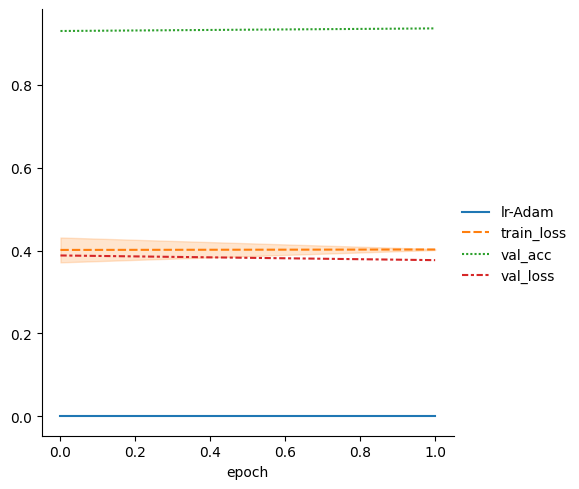

In [17]:
df = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

last_epoch = 0
for index, row in df.iterrows():
    if not np.isnan(row['epoch']):
        last_epoch = row['epoch']
    else:
        df.at[index, 'epoch'] = last_epoch
        
del df["step"]
df.set_index("epoch", inplace=True)
display(df.dropna(axis=1, how="all").head())
sn.relplot(data=df, kind="line")

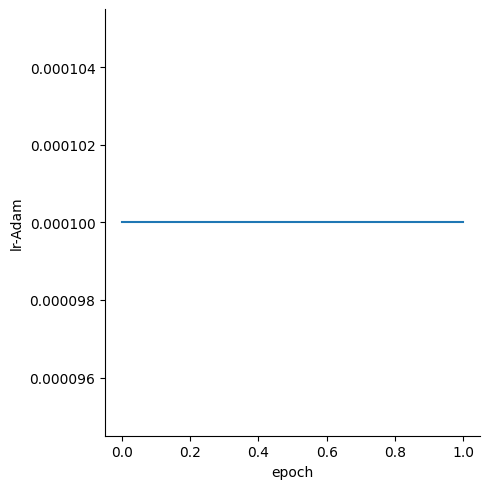

In [18]:
sn.relplot(data=df['lr-Adam'], kind="line")

In [18]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
metrics

,epoch,train_loss,step,lr-Adam,val_acc,val_loss
0,NaN,NaN,39,0.000040,NaN,NaN
1,0.0,0.328676,39,NaN,NaN,NaN
2,NaN,NaN,79,0.000040,NaN,NaN
3,0.0,0.313715,79,NaN,NaN,NaN
4,0.0,NaN,89,NaN,0.943574,0.368378
...,...,...,...,...,...,...
105,NaN,NaN,1759,0.000838,NaN,NaN
106,19.0,0.366955,1759,NaN,NaN,NaN
107,NaN,NaN,1799,0.000838,NaN,NaN
108,19.0,0.400242,1799,NaN,NaN,NaN


/tmp/ipykernel_4177264/4113246361.py:10: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.as_tensor(np.asarray(pil_image)).permute(2,0,1)


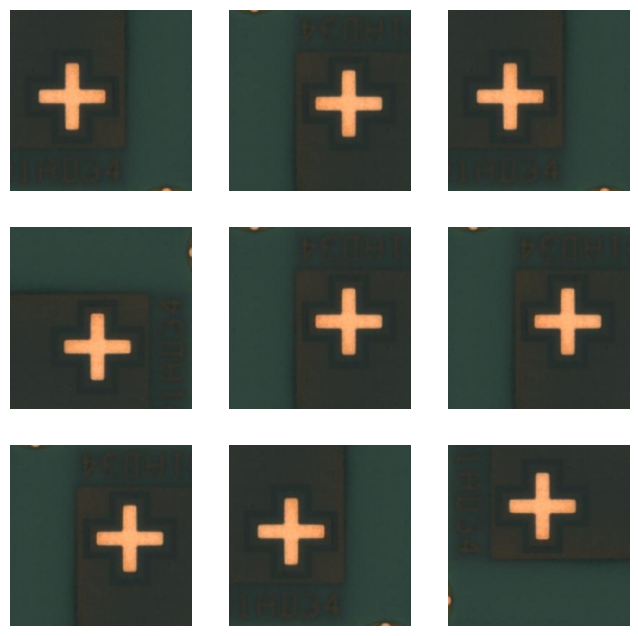

In [17]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torchvision.transforms.functional import to_pil_image

def pil_to_tensor(pil_image):
    # PIL: [width, height]
    # -> NumPy: [width, height, channel]
    # -> Tensor: [channel, width, height]
    return torch.as_tensor(np.asarray(pil_image)).permute(2,0,1)

def tensor_to_pil(tensor_image):
    return to_pil_image(tensor_image)

def tensor_to_pltimg(tensor_image):
    return tensor_image.permute(1,2,0).numpy()

## 여기를 바꿔가며 확인
transform = RotateTransform([0,90,180,270])
#######



image_path = 'PCBData/OK/DF0.jpg'
plt.figure(figsize=(8, 8))
for i in range(9):
    pil_image = PIL.Image.open(image_path)
    tensor = pil_to_tensor(pil_image)
    applied_image = transform(tensor)
    
    plt.subplot(3, 3, i+1)
    plt.imshow(tensor_to_pltimg(applied_image))
    plt.axis("off")
plt.show()

In [44]:
trainer.logger.log_dir

'/home/kotech/workspace/webstudy/deep/lightning/lightning_logs/version_1'